In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, GridSearchCV, cross_val_score
import xgboost as xgb

## Exploratory Data Analysis

In [2]:
# Data from: https://www.kaggle.com/jiashenliu/515k-hotel-reviews-data-in-europe
data = pd.read_csv('Hotel_Reviews.csv')

# remove rows with no reviews
data = data[(data['Negative_Review'] != 'No Negative') | (data['Positive_Review'] != 'No Positive')]
data.reset_index(drop=True, inplace=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515611 entries, 0 to 515610
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515611 non-null  object 
 1   Additional_Number_of_Scoring                515611 non-null  int64  
 2   Review_Date                                 515611 non-null  object 
 3   Average_Score                               515611 non-null  float64
 4   Hotel_Name                                  515611 non-null  object 
 5   Reviewer_Nationality                        515611 non-null  object 
 6   Negative_Review                             515611 non-null  object 
 7   Review_Total_Negative_Word_Counts           515611 non-null  int64  
 8   Total_Number_of_Reviews                     515611 non-null  int64  
 9   Positive_Review                             515611 non-null  object 
 

In [4]:
data.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515611.000000,515611.000000,515611.000000,515611.000000,515611.000000,515611.000000,515611.000000,512343.000000,512343.000000
mean,498.069929,8.397498,18.544017,2743.692318,17.780837,7.166319,8.395103,49.442506,2.823770
std,500.525849,0.548039,29.693061,2317.411550,21.805085,11.040812,1.637852,3.466284,4.579417
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [5]:
#how many unqiue in each column
for i in data.columns:
    print(i, len(data[i].unique()))

Hotel_Address 1493
Additional_Number_of_Scoring 480
Review_Date 731
Average_Score 34
Hotel_Name 1492
Reviewer_Nationality 227
Negative_Review 330011
Review_Total_Negative_Word_Counts 402
Total_Number_of_Reviews 1142
Positive_Review 412601
Review_Total_Positive_Word_Counts 365
Total_Number_of_Reviews_Reviewer_Has_Given 198
Reviewer_Score 37
Tags 55234
days_since_review 731
lat 1473
lng 1473


In [8]:
#Testing if there was a difference between ratings from europeans and non-europeans
europe = pd.read_html('https://en.wikipedia.org/wiki/Ethnic_groups_in_Europe')

euro = list(europe[4]['Country'])
for idx, i in enumerate(euro):
    if not i.isalpha():
        euro[idx] = i[:-3]
    if i =='United King':
        euro[idx] = 'United Kingdom'
euro[6] = 'Bosnia and Herzegovina'

euro_or_no = list(data['Reviewer_Nationality'])
for idx, i in enumerate(euro_or_no):
    euro_or_no[idx] = i[1:-1]
for idx,i in enumerate(euro_or_no):

    if i in list(euro):
        euro_or_no[idx] = 'European'
    else:
        euro_or_no[idx] = 'Not European'

data['Reviewer_Nationality'] = euro_or_no
euros = data.copy()
euros.drop(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
        'Hotel_Name',
       'Negative_Review', 
       'Total_Number_of_Reviews', 'Positive_Review',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Tags',
       'days_since_review', 'lat', 'lng'], axis=1, inplace=True)
euros.Reviewer_Nationality.unique()
euros.groupby('Reviewer_Nationality').mean()

,Average_Score,Review_Total_Negative_Word_Counts,Review_Total_Positive_Word_Counts,Reviewer_Score
Reviewer_Nationality,,,,
European,8.377590,19.597027,17.744329,8.221484
Not European,8.403115,18.246881,17.791138,8.444095


In [43]:
def city_address(address, cities):
    for city in cities:
        if city in address:
            return city
cities = ['Amsterdam', 'Vienna', 'Milan', 'Barcelona', 'Paris', 'London']
data['city'] = data['Hotel_Address'].apply(lambda x: city_address(x, cities))

In [54]:
# Checking monthly trend, consistent scoring
monthdf = data[['Review_Date','Average_Score','Reviewer_Score']]
monthdf['Review_Date'] = pd.to_datetime(monthdf['Review_Date'])
monthdf['Review_Date'] = monthdf['Review_Date'].apply(lambda x: x.strftime('%m'))
monthdf['City'] = data['city']
monthdf = monthdf.groupby(['Review_Date', 'City']).agg({'Average_Score':'mean', 'Reviewer_Score':'mean'})
monthdf.reset_index(inplace=True)
monthdf.sort_values('City')

/home/slindhult/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/slindhult/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/slindhult/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,Review_Date,City,Average_Score,Reviewer_Score
0,01,Amsterdam,8.421612,8.563347
54,10,Amsterdam,8.380524,8.371333
48,09,Amsterdam,8.405454,8.453090
42,08,Amsterdam,8.375229,8.487175
36,07,Amsterdam,8.374948,8.404112
...,...,...,...,...
17,03,Vienna,8.566039,8.649569
11,02,Vienna,8.581973,8.743946
5,01,Vienna,8.544352,8.524590
59,10,Vienna,8.563770,8.415965


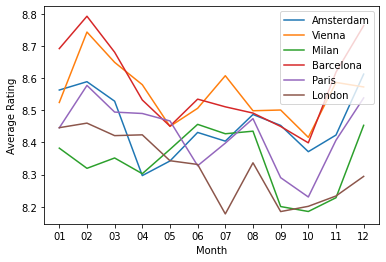

In [66]:
for i in cities:
    tempdf = monthdf[monthdf['City']==i]
    plt.plot(tempdf['Review_Date'], tempdf['Reviewer_Score'], label=i)
    plt.xlabel('Month')
    plt.ylabel('Average Rating')
    plt.legend(loc='upper right')

In [68]:
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,city
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,European,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Amsterdam
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,European,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968,Amsterdam
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Not European,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968,Amsterdam
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Not European,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968,Amsterdam
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,Not European,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968,Amsterdam


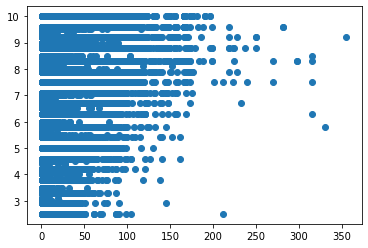

In [76]:
plt.scatter(data['Total_Number_of_Reviews_Reviewer_Has_Given'],data['Reviewer_Score'])

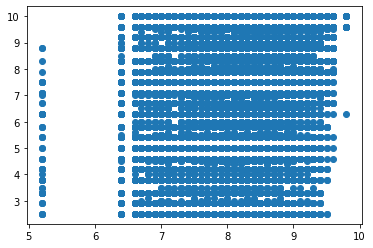

In [75]:
plt.scatter(data['Average_Score'],data['Reviewer_Score'])

Text(0, 0.5, 'Occurrences')

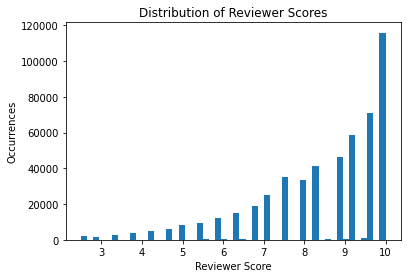

In [84]:
plt.hist(data['Reviewer_Score'], bins=50);
plt.title('Distribution of Reviewer Scores')
plt.xlabel('Reviewer Score')
plt.ylabel('Occurrences')

## Cleaning the Data

In [ ]:
#Drop unwanted columns
data.drop(['Hotel_Name','Hotel_Address','Review_Date','days_since_review', 'lat', 'lng'],  axis=1, inplace=True)
data['Average_Score'].astype(float)

In [ ]:
#correcting tags from 55,000 to a few - started as a list of strings that looked like lists of strings
tags = data.Tags

import ast
new_tags = []
for i in tags:
    new_tags.append(ast.literal_eval(i))

In [ ]:
# check most common tags
from collections import Counter
list_for_counting = []
for i in new_tags:
    for t in i:
        list_for_counting.append(t)
    
c = Counter(list_for_counting)
c.most_common(20)      

In [ ]:
#feature engineering tags to reduce columns
for index, i in enumerate(new_tags):
    for idx, t in enumerate(i):
        if t not in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Stayed 5+ nights', 'Fancy', 'Budget', 'Medium', 'High', ' Business trip ', ' Solo traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
            if t in [' Stayed 1 night ',' Stayed 2 nights ']:
                new_tags[index][idx] = 'Stayed 1-2 nights'
            if t in [' Stayed 3 nights ',' Stayed 4 nights ']:
                new_tags[index][idx] = 'Stayed 3-4 nights'
            if t in [' Stayed 5 nights ',' Stayed 6 nights ', ' Stayed 7 nights ', ' Stayed 8 nights ', ' Stayed 9 nights ', ' Stayed 10 nights ',  ' Stayed 11 nights ',
                 ' Stayed 12 nights ', ' Stayed 13 nights ', ' Stayed 14 nights ', ' Stayed 15 nights ', ' Stayed 16 nights ', ' Stayed 17 nights ',' Stayed 18 nights ', ' Stayed 19 nights ', ' Stayed 20 nights ',
                 ' Stayed 21 nights ', ' Stayed 22 nights ', ' Stayed 23 nights ', ' Stayed 24 nights ', ' Stayed 25 nights ', ' Stayed 26 nights ',
                 ' Stayed 27 nights ', ' Stayed 28 nights ', ' Stayed 29 nights ', ' Stayed 30 nights ', ' Stayed 31 nights ',]:
                new_tags[index][idx] = 'Stayed 5+ nights'
            if 'Luxury' in t or 'VIP' in t or 'Executive' in t or 'Ambassador' in t or 'Royal' in t or 'Penthouse' in t or 'Suite' in t or 'Duplex' in t or 'Presidential' in t or 'Apartment' in t or 'Apartement' in t:
                new_tags[index][idx] = 'Fancy'
            if 'Superior' in t or 'Premium' in t or 'Prestige' in t or 'Premiere' in t or 'Privilege' in t or 'Deluxe' in t or 'Premier' in t or 'Club' in t or 'View' in t or 'Art' in t or 'Fabulous' in t or 'Wonderful' in t or 'Loft' in t or 'Eiffel' in t or 'Spa' in t or 'King' in t:
                new_tags[index][idx] = 'High'
            if 'Standard' in t or 'Budget' in t or 'Small' in t or 'Economy' in t or 'Basic' in t or 'Bunk Bed' in t or 'Interior' in t or 'Special Offer' in t or 'Triple' in t or 'Quadruple' in t or 'Quintuple' in t or 'Sextuple' in t or 'Junior' in t or 'Twin' in t or 'Mini' in t or 'Check In' in t or 'Check in' in t or'Solo' in t or 'Camper' in t or 'Rooms' in t or 'Interconnecting' in t or 'FAMILY' in t or 'Atrium' in t or 'rooms' in t:
                new_tags[index][idx] = 'Budget'
            if 'Comfort' in t or 'Family' in t or 'Classic' in t or 'Large' in t or 'Double' in t or 'Cosy' in t or 'Single' in t or 'Connecting' in t or 'Queen' in t or 'Cozy' in t or 'Studio' in t or 'Adjacent' in t or 'Two' in t:
                new_tags[index][idx] = 'Medium'
            
for index, i in enumerate(new_tags):
    for idx, t in enumerate(i):            
            if t not in ['Stayed 1-2 nights','Stayed 3-4 nights', 'Stayed 5+ nights', 'Fancy', 'Budget', 'Medium', 'High', ' Business trip ', ' Solo traveler ', ' Leisure trip ', ' Couple ', ' Group ', ' Family with young children ', ' Family with older children ']:
                   new_tags[index][idx] = 'High'

In [ ]:
unique_tags = []
for i in new_tags:
    for t in i:
        if t not in unique_tags:
            unique_tags.append(t)

In [ ]:
#Replace tags with feature engineered tags
data['New_Tags'] = new_tags

In [ ]:
#Onehotencode tags and drop the old columns
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

tagdf = pd.DataFrame(mlb.fit_transform(data.New_Tags),columns=mlb.classes_, index=data.index)


data = data.join(tagdf)
data = data.drop(['New_Tags'], axis=1)
data.drop('Tags', axis=1, inplace=True)

In [ ]:
data = data.drop(['Reviewer_Nationality'], axis=1)

In [ ]:
#clean = clean.to_csv('clean.csv')

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", " "))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", " "))

In [ ]:
neg = data["Negative_Review"]
pos = data["Positive_Review"]

In [ ]:
from textblob import TextBlob
neg_review_sentiment = []
for i in neg:
    review = TextBlob(i)
    neg_review_sentiment.append(review.sentiment)


In [ ]:
neg_review_sentiments = [i.polarity for i in neg_review_sentiment]
data['neg_review_sentiment'] = neg_review_sentiments

In [ ]:
pos_review_sentiment = []
for i in pos:
    review = TextBlob(i)
    pos_review_sentiment.append(review.sentiment)

In [ ]:
pos_review_sentiments = [i.polarity for i in pos_review_sentiment]
data['pos_review_sentiment'] = pos_review_sentiments

In [ ]:
#remove stopwords and lemmatize reviews for nmf and most frequent word comparisons
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

data['Neg_Review_Clean'] = data['Negative_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filtered = []
for i in data['Neg_Review_Clean']:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w.lower()) for w in i if w not in stop_words]
    filtered.append(' '.join(filtered_sentence))
    
data['Neg_Review_Clean'] = filtered

In [ ]:
#remove stopwords and lemmatize reviews
data['Pos_Review_Clean'] = data['Positive_Review']

filteredpos = []
for i in data['Pos_Review_Clean']:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w) for w in i if w not in stop_words]
    filteredpos.append(' '.join(filtered_sentence))
    
data['Pos_Review_Clean'] = filteredpos

In [ ]:
data

In [ ]:
data.to_csv('cleanest.csv')

In [ ]:
#Making same dataset using vader sentiment analysis for comparison

In [ ]:
cleanest = pd.read_csv('cleanest.csv')
#cleanest.fillna(' ', inplace=True)
#cleanest.drop(['Unnamed: 0','Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
cleanest

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

pos = cleanest['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
neg = cleanest['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])

In [ ]:
cleanest['vader_pos_sent'] = pos_review_sentiment
cleanest['vader_neg_sent'] = neg_review_sentiment

In [ ]:
cleanest.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)

In [ ]:
cleanest.drop(['Positive_Review', 'Negative_Review'], axis=1, inplace=True)

In [ ]:
cleanest.to_csv('vader.csv')

## Modeling

In [ ]:
# has textblob sentiment
cleanest = pd.read_csv('cleanest.csv')
cleanest.fillna(' ', inplace=True)
cleanest.drop(['Unnamed: 0', 'Negative_Review', 'Positive_Review', 'Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
#Drop due to colinearity with total reviews
cleanest.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

### Modeling with Textblob sentiment analysis

In [ ]:
# Benchmark - error if you always guessed the average (1.18)
mean_absolute_error(cleanest['Average_Score'], cleanest['Reviewer_Score'])

In [ ]:
y = cleanest.pop('Reviewer_Score')
X = cleanest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 30,
                          max_depth=25,
                          max_features=10,
                          n_estimators=500)

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
#Out of the box random forest with textblob sentiment analysis: 0.8860822932892579

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.05,
                                  loss='ls',
                                 max_depth=15,
                                  n_estimators=500,
                                 min_samples_leaf=120,
                                 max_features=15,
                                  random_state=1)

In [ ]:
gdbr.fit(X_train, y_train)

In [ ]:
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
#Out of the box gradient boost with textblob analysis: 0.8735888232428165 

In [ ]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] =6
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 250
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)
mean_absolute_error(y_test,pred)

In [ ]:
#Out of the box XGboost with textblob sentiment analysis: 0.8773096008942032

### Modeling with original data

In [ ]:
cleanest.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)

In [ ]:
X = cleanest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
#Out of the box random forest no sentiment analysis: 0.9172898922210799

In [ ]:
gdbr.fit(X_train, y_train)
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
#Out of the box gradient boost: 0.9180026868600099 

In [ ]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] =6
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 250


In [ ]:
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)
mean_absolute_error(y_test,pred)

In [ ]:
#Out of the box XGboost: 0.9150395736506789 

### Modeling with Vader Sentiment Analysis

In [ ]:
vader = pd.read_csv('vader.csv')
vader.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
vader.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

In [ ]:
y = vader.pop('Reviewer_Score')
X = vader

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)

In [ ]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
##Out of the box random forest with vader sentiment analysis:0.864468939011441

In [ ]:
gdbr.fit(X_train, y_train)
y_hat = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
#Out of the box gradient boost with vader sentiment analysis: 0.864468939011441

In [ ]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.05
param['max_depth'] =6
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 250
bst = xgb.train(param, xg_train, num_round, watchlist)
pred = bst.predict(xg_test)
mean_absolute_error(y_test,pred)

In [ ]:
mean_squared_error(y_test, pred)**0.5

In [ ]:
mean_squared_error(y, vader['Average_Score'])**0.5

In [ ]:
#Out of the box XGboost with vader sentiment analysis:  0.8603997258088616

In [ ]:
# Vader slightly better, will proceed with vader sentiment analysis

### Add count vector of top 300 words from each positive and negative reviews

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
cleanest = pd.read_csv('cleanest.csv')
count = CountVectorizer(max_features=300, stop_words='english')


In [ ]:
fitted_pos = count.fit_transform(cleanest['Pos_Review_Clean'].values.astype('U'))
pos_col_names = count.get_feature_names()
fitted_pos = fitted_pos.todense()
fitted_pos = pd.DataFrame(fitted_pos, columns = pos_col_names)

In [ ]:
vader = vader.join(fitted_pos)

In [ ]:
fitted_neg = count.fit_transform(cleanest['Neg_Review_Clean'].values.astype('U'))
neg_col_names = count.get_feature_names()
fitted_neg = fitted_neg.todense()
fitted_neg = pd.DataFrame(fitted_neg, columns = neg_col_names)
fitted_neg = fitted_neg.add_suffix('_neg')
vader = vader.join(fitted_neg)

In [ ]:
vader.to_csv('vadercountfinal')

In [ ]:
vadercountfinal = pd.read_csv('vadercountfinal.csv')

In [ ]:
y = vadercountfinal.pop('Reviewer_Score')
X = vadercountfinal

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 30,
                          max_depth=25,
                          max_features=10,
                          n_estimators=500)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
#Out of the box random forest with vader and count vectorize: 0.9482405860580165

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.05,
                                  loss='ls',
                                 max_depth=15,
                                  n_estimators=500,
                                 min_samples_leaf=120,
                                 max_features=10,
                                  random_state=1)
gdbr.fit(X_train, y_train)
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
#Out of the box gradient boost with vader and count vectorizer: 0.7937548145846729

In [ ]:
vadercountfinal = pd.read_csv('vadercountfinal.csv')
X = vadercountfinal
y = y
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix(X_test, label=y_test)
param = {}
# I used gamma regression 
param['objective'] = 'reg:gamma'
param['eta'] = 0.02
param['max_depth'] = 10
param['silent'] = 0
param['nthread'] = 4
watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 2000

In [ ]:
pred = bst2.predict(xg_test)
mean_absolute_error(y_test,pred)

In [ ]:
# Best tuned XGBoost: 0.7745135257798303

In [ ]:
rf = RandomForestRegressor(min_samples_leaf = 5,
                          max_depth=30,
                          max_features=60,
                          n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mean_absolute_error(y_test, y_pred)

In [ ]:
# Best tuned random forest: .8199

In [ ]:
gdbr = GradientBoostingRegressor(learning_rate=0.01,
                                  loss='ls',
                                 max_depth=35,
                                  n_estimators=1250,
                                 min_samples_leaf=80,
                                 max_features=70,
                                  random_state=1)

gdbr.fit(X_train, y_train)
y_hat = gdbr.predict(X_test)
mean_absolute_error(y_test, y_hat)

In [ ]:
#Best tuned gradient boosting regressor: 0.764065461073389

In [ ]:
vadercount = pd.read_csv('vadercountfinal.csv')

In [ ]:
vadercount.columns

In [ ]:
vadercount.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1'], axis=1, inplace=True)

In [ ]:
y = pd.read_csv('y.csv')

In [ ]:
Xv = vadercount
y = y['Reviewer_Score']

In [ ]:
#y.to_csv('y.csv')

In [ ]:
y.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv,y, test_size=.2)

In [ ]:
range_of_model = y_test-yboost2

In [ ]:
#Largest Guess over
range_of_model.min()

In [ ]:
Lowest Guess Below
range_of_model.max()

In [ ]:
np.mean(range_of_model)

In [ ]:
feats_dict = bst.get_score(importance_type='gain')

In [ ]:
items = feats_dict.items()

In [ ]:
sorted(feats_dict.values())

In [ ]:
#Testing without average score
sans_average = clean
sans_average.drop('Average_Score', axis=1, inplace=True)

In [ ]:
XA_train, XA_test, y2_train, y2_test = train_test_split(sans_average, y, test_size=0.2)

In [ ]:

gdbr2 = GradientBoostingRegressor(max_depth=30, max_leaf_nodes=40, min_samples_leaf=50, n_estimators=100)

gdbr2.fit(XA_train, y2_train)

In [ ]:
yboost2A = gdbr2.predict(XA_test)
mean_absolute_error(y_test, yboost2A)

In [ ]:
r2_score(y_test, yboost2A)

In [ ]:
columns = ['Original', 'Textblob', 'vader']
random_forest = [0.917, 0.886, 0.864]
gradient_boost = [0.918, 0.874, 0.864] 
XGBoost = [ 0.915, 0.878, 0.860]

In [ ]:
model_comparison = pd.DataFrame(data=[random_forest, gradient_boost, XGBoost], columns=columns, index=['Random Forest', 'Gradient Boost', 'XGBoost'])

In [ ]:
model_comparison

In [ ]:
labels = ['Original Random Forest', 'Original Gradient Boost', 'Original XGBoost', 'Textblob Random Forest', 'Textblob Gradient Boost', 'Textblob XGBoost']
values = [0.917, 0.918, 0.915, 0.886, 0.874, 0.878]



In [ ]:
original = [0.918, 0.920, 0.916]
textblob = [0.885, 0.874, 0.879]
vadergraph = [0.864, 0.864, 0.860]
vadercountvectorizer = [0.812, 0.764, 0.774]



N = 3
ind = np.array((0,1,2))
width = 0.25
fig= plt.figure(figsize=(12,6))
rects1 = plt.bar(ind, original, 4/5*width, label='Original Dataset')
rects2 = plt.bar(ind + width, textblob, 4/5*width,
    label='With Textblob')
rects3 = plt.bar(ind + 2*width, vadergraph, 4/5*width,
    label='With Vader')
rects4 = plt.bar(ind + 3*width, vadercountvectorizer, 4/5*width,
    label='Vader CountVectorizer')



plt.ylabel('Mean Absolute Error')
plt.title('Scores by dataset and model')
plt.axis([-.25,3,0.7,0.95])
plt.xticks(ind + 1.5*width, ('Random Forest', 'Gradient Boost', 'XGBoost'))
plt.legend(loc='best')


def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        plt.text(rect.get_x()+rect.get_width()/2., 1*h, h,
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()
fig.savefig('Hotel-Reviews/images/modelcomparison.png')

In [ ]:
#Using a dictionary to find word occurrences

In [ ]:
negative_words = {}
for i in negative_reviews:
    try:
        for w in i.split():
            if w not in negative_words.keys():
                negative_words[w] = 0
            negative_words[w] +=1
    except AttributeError:
        continue
        

In [ ]:
top_list = sorted(negative_words.values())[::-1][:30]
for k,v in negative_words.items():
    if v in top_list:
        print(k)

In [ ]:
positive_words = {}
for i in positive_reviews:
    try:
        for w in i.split():
            if w not in positive_words.keys():
                positive_words[w] = 0
            positive_words[w] +=1
    except AttributeError:
        continue

In [ ]:
top_list = sorted(negative_words.values())[::-1][:30]
for k,v in negative_words.items():
    if v in top_list:
        print(k)

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
neg_content = cleanest['Neg_Review_Clean']
pos_content = cleanest['Pos_Review_Clean']

In [ ]:
word_tokenize(neg_content)

In [ ]:
# try ngrams 2,2
count = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(2,2))

In [ ]:
fitted_neg = count.fit_transform(cleanest['Neg_Review_Clean'].values.astype('U')) 
fitted_pos = count.fit_transform(cleanest['Pos_Review_Clean'].values.astype('U'))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_pos = tfidf.fit_transform(cleanest['Pos_Review_Clean'].values.astype('U'))


In [ ]:
tfidf_neg = tfidf.fit_transform(cleanest['Neg_Review_Clean'].values.astype('U'))

In [ ]:
tfidf_pos = tfidf_pos.toarray()

In [ ]:
tfidf_neg.toarray()

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
from sklearn.decomposition import NMF
def fit_nmf(r):
    nmf = NMF(n_components=r)
    nmf.fit(fitted_neg)
    W = nmf.transform(fitted_neg)
    H = nmf.components_
    return nmf.reconstruction_err_


fit_nmf(10)
error = [fit_nmf(i) for i in range(1,11)]
plt.plot(range(1,11), error)
plt.xticks(range(1, 11))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')

In [ ]:
words = count.get_feature_names()

In [ ]:
words2 = count2.get_feature_names()

In [ ]:
def fit_nmf_pos(r):
    nmf = NMF(n_components=r)
    nmf.fit(fitted_pos)
    W = nmf.transform(fitted_pos)
    H = nmf.components_
    return nmf.reconstruction_err_

fit_nmf_pos(8)
error = [fit_nmf(i) for i in range(1,10)]
plt.plot(range(1,10), error)
plt.xticks(range(1, 10))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')

In [ ]:
count3 = CountVectorizer(max_features=1000, stop_words='english', ngram_range=(3,3))

In [ ]:
words3 = count3.get_feature_names()

In [ ]:
fitted_neg3 = count3.fit_transform(neg_content.values.astype('U')) 
fitted_pos3 = count3.fit_transform(pos_content.values.astype('U'))

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(fitted_neg3)
H = model.components_

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:10]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words3[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [ ]:
from sklearn.decomposition import NMF
model = NMF(n_components=3, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:30]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [ ]:

model = NMF(n_components=20, init='random', random_state=0)
W = model.fit_transform(fitted_neg)
H = model.components_

In [ ]:
H.shape

In [ ]:
associated = []
for i in H:
    associated.append((np.argsort(i)[::-1][:10]))

In [ ]:
topics = []
for num, i in enumerate(associated):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics.append(lst)
    print(f'topic{num+1} :', lst)

In [ ]:
from sklearn.decomposition import NMF

model = NMF(n_components=3, init='random', random_state=0)
W2 = model.fit_transform(fitted_neg)
H2 = model.components_

In [ ]:
associated_pos = []
for i in H2:
    associated_pos.append((np.argsort(i)[::-1]))

In [ ]:
topics_pos = []
for num, i in enumerate(associated_pos):
    lst = []
    for idx in i:
        lst.append(words[idx])
    topics_pos.append(lst)
    print(f'topic{num+1} :', lst)

In [ ]:
from textblob import TextBlob

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

data['Neg_Review_Clean'] = data['Negative_Review']

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

filtered = []
for i in data['Neg_Review_Clean'][:2]:
    i = i.split()
    filtered_sentence = [lem.lemmatize(w) for w in i if w not in stop_words]
    filtered.append(' '.join(filtered_sentence))

In [ ]:
data['Neg_Review_Clean'][0]

In [ ]:
datafiltered[0]

## Word Clouds

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [40, 10]

# Create subplots for each Topic
for index, topic in enumerate(topics_pos):
    wc = WordCloud(width = 1000, height = 500).generate(' '.join(topic))
    
    plt.subplot(2, 5, index+1)
    plt.imshow(wc, interpolation="quadric")
    plt.axis("off")
    #plt.title(hand_labels[index])
    
plt.show()

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 25,
        max_font_size = 30, 
        scale = 3,
    ).generate(str(data))

    fig = plt.figure(1, figsize = (10, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.tight_layout()
    plt.show()

    return fig
# print wordcloud
fig = show_wordcloud(topics_pos[0])
fig.savefig('Hotel-Reviews/images/topic1.jpg')


In [ ]:
fig2 = show_wordcloud(topics_pos[1])
fig2.savefig('Hotel-Reviews/images/topic2.jpg')


In [ ]:
fig3 = show_wordcloud(topics_pos[2])
fig3.savefig('Hotel-Reviews/images/topic3.jpg')

In [ ]:
show_wordcloud(fitted_neg)

## Mapping

In [ ]:
mapdf = data[['Hotel_Name', 'Average_Score', 'lat', 'lng']]
mapdf = mapdf.groupby(['Hotel_Name']).agg({'Average_Score':'mean', 'lat':'mean', 'lng':'mean'})
mapdf = mapdf.dropna()
mapdf.reset_index(inplace=True)

In [ ]:
mapdf['color'] = pd.cut(mapdf['Average_Score'], bins=[0,8.1,8.5,8.9,10], 
                              labels=['red', 'orange', 'blue', 'green'])

In [ ]:
import folium
m = folium.Map(location=[52.360576, 4.915968])

image_file='legend.png'

FloatImage(image_file,bottom=5,left=5).add_to(m)

for i in range(mapdf.shape[0]):
    folium.CircleMarker([mapdf['lat'][i],mapdf['lng'][i]], radius=2,tooltip=f'{mapdf["Hotel_Name"][i]} : {mapdf["Average_Score"][i]:0.2}', color=mapdf['color'][i]).add_to(m)
m

In [ ]:
from folium.plugins import FloatImage


import folium
b = folium.Map(location=[52.360576, 4.915968])
# convert to (n, 2) nd-array format for heatmap
import folium.plugins as plugins
lat = np.array(mapdf['lat'])
lng = np.array(mapdf['lng'])
coords = []
for i,j in zip(lat,lng):
    coords.append((i,j))
hotels = np.array(coords)


'''steps = 20
color_map=cm.linear.BuGrYlRd.scale(0,1).to_step(steps)

gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = color_map.rgb_hex_str(1/steps*i)'''



image_file='legend.png'

FloatImage(image_file,bottom=5,left=5).add_to(b)

# plot heatmap
for i in range(mapdf.shape[0]):
    folium.CircleMarker([mapdf['lat'][i],mapdf['lng'][i]], radius=2, tooltip=f'{mapdf["Hotel_Name"][i]} : {mapdf["Average_Score"][i]:0.2}', color=mapdf['color'][i]).add_to(b)


b.add_children(plugins.HeatMap(hotels, radius=30))
b



In [ ]:
mapdata = np.array(mapdf[['lat', 'lng','Average_Score']])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_pos = count.fit_transform(pos_content.values.astype('U'))
tfidf_neg = count.fit_transform(neg_content.values.astype('U'))

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

analyser = SentimentIntensityAnalyzer()

In [ ]:
a = analyser.lexicon.keys()
b = analyser.lexicon.values()

In [ ]:
hotel_lexicon = {k:v for k,v in zip(a,b)}

In [ ]:
hotel_lexicon['small']

In [ ]:
snt = analyser.polarity_scores('No Positive')

In [ ]:
snt['compound']

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
neg = data['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])


In [ ]:
pos = data['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
vader

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
cleanest["Neg_Review_Clean"] = cleanest["Neg_Review_Clean"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Pos_Review_Clean"] = cleanest["Pos_Review_Clean"].apply(lambda x: str(x).replace("No Positive", ""))
                                                                  

In [ ]:
cleanest

In [ ]:
vader = cleanest.copy()

In [ ]:
#vader.drop(['neg_review_sentiment', 'pos_review_sentiment'], axis=1, inplace=True)

vader['pos_sent'] = pos_review_sentiment
vader['neg_sent'] = neg_review_sentiment

In [ ]:
vader.drop(['Unnamed: 0', 'Unnamed: 0.1','Neg_Review_Clean', 'Pos_Review_Clean'], axis=1, inplace=True)

In [ ]:
vader.to_csv('vader.csv')

In [ ]:
vader.drop('Additional_Number_of_Scoring', axis=1, inplace=True)

In [ ]:
vader[vader['pos_sent']<-0.5]

In [ ]:
vader[vader['neg_sent']>0]

In [ ]:
data['Positive_Review'][577]

In [ ]:
vader

In [ ]:
data['Hotel_Address'][455551]

In [ ]:
city = data['Hotel_Address']
for idx, i in enumerate(city):
    if 'Amsterdam' in i:
        city[idx] = 'Amsterdam'
    if 'Vienna' in i:
        city[idx] = 'Vienna'
    if 'Milan' in i:
        city[idx] = 'Milan'
    if 'Barcelona' in i:
        city[idx] = 'Barcelona'
    if 'Paris' in i:
        city[idx] = 'Paris'
    if 'London' in i:
        city[idx] = 'London'
city = pd.Series(city)

In [ ]:
city = pd.Series(city)

In [ ]:
vader['City'] = city

In [ ]:
cities = pd.get_dummies(vader['City'])
vader = vader.join(cities)
vader.drop(['City'], axis=1, inplace=True)

In [ ]:
vader

In [ ]:
data.head()

In [ ]:
cleanest = pd.read_csv('cleanest.csv')

In [ ]:
cleanest["Negative_Review"] = cleanest["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Positive_Review"] = cleanest["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))
cleanest["Neg_Review_Clean"] = cleanest["Neg_Review_Clean"].apply(lambda x: str(x).replace("No Negative", ""))
cleanest["Pos_Review_Clean"] = cleanest["Pos_Review_Clean"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
cleanest["Pos_Review_Clean"][3]

In [ ]:
spell = SpellChecker()
sp = []
for i in cleanest['Pos_Review_Clean']:
    misspelled = spell.unknown(word_tokenize(i))
    for w in misspelled:
        sp.append(w)

In [ ]:
sorted(set(sp))

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')

In [ ]:
cleanest['differential'] = cleanest['Reviewer_Score'] - data['Average_Score']

In [ ]:
neg_dict = {}
for idx, i in enumerate(cleanest['Neg_Review_Clean']):
    try:
        for w in word_tokenize(i):
            if w.isalpha():
                w=w.lower()
                if w not in neg_dict.keys():
                    neg_dict[w] = 0
                neg_dict[w] -=1
    except TypeError:
        continue

In [ ]:
sorted(neg_dict.values())

In [ ]:
pos_dict = {}
for i in cleanest['Pos_Review_Clean']:
    try:
        for w in word_tokenize(i):
            w=w.lower()
            if w.isalpha():
                if w not in pos_dict.keys():
                    pos_dict[w] = 0

                pos_dict[w]+=1
    except TypeError:
        continue            


In [ ]:
sorted(pos_dict.values())[::-1]

In [ ]:
len(pos_dict.keys())

In [ ]:
len(neg_dict.keys())

In [ ]:
merged_dict = neg_dict.copy()

for i in pos_dict.keys():
    if i not in merged_dict.keys():
        merged_dict[i]=0
    merged_dict[i] += pos_dict[i]

In [ ]:
top_neg = sorted(merged_dict.items(), key=(lambda item: item[1]))[:55]

In [ ]:
top_pos = sorted(merged_dict.items(), key=(lambda item: item[1]))[73480:]

In [ ]:
#top_pos[::-1]

In [ ]:
a = analyser.lexicon.keys()
b = analyser.lexicon.values()

In [ ]:
hotel_lexicon = {k:v for k,v in zip(a,b)}

In [ ]:
in_lexicon = []
for i in top_pos:
    if i[0] in hotel_lexicon.keys():
        in_lexicon.append((i[0], hotel_lexicon[i[0]]))
    else:
        in_lexicon.append(i)

In [ ]:
pos_in_lexicon = [i for i in in_lexicon if i[1]>4]

In [ ]:
nin_lexicon = []
for i in top_neg:
    if i[0] in hotel_lexicon.keys():
        nin_lexicon.append((i[0], hotel_lexicon[i[0]]))
    else:
        nin_lexicon.append(i)

In [ ]:
neg_in_lexicon = [i for i in nin_lexicon if i[1]<-4]

In [ ]:
neg_in_lexicon 

In [ ]:
w_pos_in_lexicon = [i[0] for i in pos_in_lexicon]
w_neg_in_lexicon = [i[0] for i in neg_in_lexicon]

In [ ]:
#w_neg_in_lexicon

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
#vader3
'''pos_words = {'large':1.5,
 'minute':1,
 'convenient':1.5,
 'walking':1,
 'near':1,
 'central':1,
 'view':1,
 'walk':1,
 'spacious':2,
 'modern':2,
 'everything':1,
 'quiet':1,
 'comfy':1,
 'close':1,
 'location':1.5}

neg_words = {
 'small': -2,
 'little':-2,
 'expensive': -2,
 'work':-1,
 'not':-1,
 'air':-0.5,
 'noise': -2,
 'told':-0.5,
 'bathroom':-1,
 'water':-1,
 'booking': -1,
 'hot':-1,
 'shower':-2,
 'cold': -3,
 'price':-1,
 'slow': -2,
 'booked':-1,
 'old':-1,
 'paid':-0.5,
 'toilet':-1,
 'tiny':-2,
 'working':-1}
'''

#vader4
pos_words = {'large':1.5,
 'minute':1,
 'convenient':1.5,
 'walking':1,
 'near':1,
 'central':1,
 'view':1,
 'walk':1,
 'spacious':2,
 'modern':2,
 'everything':1,
 'quiet':1,
 'comfy':1,
 'close':1,
 'location':1.5}

neg_words = {
 'i':-.05
 'small': -2,
 'little':-2,
 'expensive': -2,
 'work':-1,
 'not':-1,
 'air':-1,
 'noise': -2,
 'told':-0.5,
 'bathroom':-1,
 'water':-1,
 'booking': -1,
 'hot':-1,
 'shower':-2,
 'cold': -3,
 'price':-1,
 'slow': -2,
 'booked':-1,
 'old':-1,
 'paid':-0.5,
 'toilet':-1,
 'tiny':-2,
 'working':-1}
analyser = SentimentIntensityAnalyzer()

analyser.lexicon.update(pos_words)
analyser.lexicon.update(neg_words)

In [ ]:
vader = pd.read_csv('vader.csv')

In [ ]:
data["Negative_Review"] = data["Negative_Review"].apply(lambda x: str(x).replace("No Negative", ""))
data["Positive_Review"] = data["Positive_Review"].apply(lambda x: str(x).replace("No Positive", ""))

In [ ]:
pos = data['Positive_Review']
pos_review_sentiment = []
for i in pos:
    snt = analyser.polarity_scores(i)
    pos_review_sentiment.append(snt['compound'])


In [ ]:
neg = data['Negative_Review']
neg_review_sentiment = []
for i in neg:
    snt = analyser.polarity_scores(i)
    neg_review_sentiment.append(snt['compound'])

In [ ]:
vader3 = vader2.copy()
vader3['new_pos_sent'] = pos_review_sentiment
vader3['New_neg_sent'] = neg_review_sentiment


In [ ]:
vader3.to_csv('vader3.csv')

In [ ]:
vader2.head()

In [ ]:
vader2.to_csv('vader2.csv')

In [ ]:
vader2 = pd.read_csv('vader2.csv')

In [ ]:
vader2.drop(['pos_sent', 'neg_sent'],axis=1, inplace=True)

In [ ]:
#y = vader3.pop('Reviewer_Score')
#Xv2 = vader3
Xv2_train, Xv2_test, yv2_train, yv2_test = train_test_split(Xv,y, test_size=.2)

In [ ]:
rf = RandomForestRegressor(max_depth=20, max_features=15, min_samples_leaf=10,
                      n_estimators=500,)

In [ ]:
#0.8644864926810877 vader, vader2: 0.8652860490218461, v3: 0.8591603772526949

rf.fit(Xv_train, yv2_train)

yvadersearch = rf.predict(Xv2_test)
mean_absolute_error(yv2_test, yvadersearch)

In [ ]:
rf = RandomForestRegressor(max_depth=50, max_features=70, min_samples_leaf=30,
                      n_estimators=750,)

In [ ]:
rf.fit(Xv_train, yv_train)

yvadersearch = rf.predict(Xv_test)
mean_absolute_error(yv_test, yvadersearch)

In [ ]:
resid = (yvadersearch-yv_test)

In [ ]:
max(yv_test)

In [ ]:
difference

In [ ]:
print(f'{np.mean(difference)})
print(min(difference)) #max overguess
print(max(difference)) # max underguess

In [ ]:
plt.bar(yv_test,resid)

In [ ]:
len(edited_dict.items())

In [ ]:
sorted(edited_dict.items(), key=(lambda item: item[1]))

In [ ]:
sent_dict = {key:val for key, val in merged_dict.items() if key in edited_dict.keys()}

In [ ]:
sent_dict

In [ ]:
lst = [('Location', 182356),
 ('Staff', 156235),
 ('Good', 91507),
 ('Friendly', 80715),
 ('Helpful', 71799),
 ('Excellent', 59915),
 ('Nice', 59561),
 ('Clean', 58436),
 ('Comfortable', 54418),
 ('Hotel', 49731)]
words = []
vals = []
for i in lst:
    words.append(i[0])
    vals.append(i[1])


In [ ]:
pos_words = pd.DataFrame([words,vals])

In [ ]:
pos_words=pos_words.T

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(pos_words[0], pos_words[1], color='green')
ax.xaxis.set_tick_params(labelsize=16, rotation=45, )
ax.set_xlabel('Positive Words', fontsize=18)
ax.set_ylabel('Relative Occurrences', fontsize=18)
fig.suptitle('Top 10 Positive Words', fontsize=20);
plt.savefig('Hotel-Reviews/images/poswords.jpg')

In [ ]:
neglst = [ 
('I', 54831),
 ('Small', 38226),
 ('Nothing', 32126),
 ('Room', 29869),
 ('Bit', 23675),
 ('Could', 22721),
 ('Poor', 15300),
 ('Little', 15107),
 ('Expensive', 14225),
 ('Noisy', 12803)
]
words = []
vals = []
for i in neglst:
    words.append(i[0])
    vals.append(i[1])

In [ ]:
neg_words = pd.DataFrame([words,vals])
neg_words=neg_words.T

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.bar(neg_words[0], neg_words[1], color='red')
ax.xaxis.set_tick_params(labelsize=16, rotation=45)
ax.set_xlabel('Negative Words', fontsize=18)
ax.set_ylabel('Relative Occurrences', fontsize=18)
fig.suptitle('Top 10 Negative Words', fontsize=20);
plt.savefig('Hotel-Reviews/images/negwords.jpg')

In [ ]:
featurelist = [('fabulous', 0.29964397592170217), ('room', 0.30194291249199645), ('Review_Total_Positive_Word_Counts', 0.3052570176688559), ('view_neg', 0.3065943580036194), ('customer_neg', 0.309148504285848), ('like', 0.3097000750242623), ('cleaned_neg', 0.3138296421587767), ('far_neg', 0.31415213928598024), ('experience_neg', 0.3160898314851383), ('upgraded', 0.31808503933448273), ('uncomfortable_neg', 0.3181067243519525), ('amazing', 0.32032346693149794), ('positive', 0.3268533664683133), ('friendly_neg', 0.3279204781542303), ('star', 0.3316088215976614), ('money', 0.33323600792235114), ('furniture_neg', 0.33556941761333337), ('thing_neg', 0.3359991773269183), ('basic_neg', 0.3371390389734257), ('worth_neg', 0.34183704961622896), ('bad_neg', 0.35738071688622886), ('excellent', 0.3594808207557529), ('service', 0.359927338350747), ('good', 0.36450212979652796), ('value_neg', 0.36939321877731096), ('Average_Score', 0.37155553164158), ('maybe_neg', 0.3742655712045161), ('slightly_neg', 0.3756614262933333), ('problem_neg', 0.37852534112012903), ('negative_neg', 0.3795259726073531), ('liked_neg', 0.3798875420290196), ('loved', 0.38373564215679484), (' Leisure trip ', 0.3845988736897397), ('thing', 0.3854006269861976), ('tiny_neg', 0.3855309579764056), ('smell_neg', 0.39104875876111), ('comfort', 0.396663971459846), ('service_neg', 0.40567563202398277), ('poor_neg', 0.40716188873969195), ('location', 0.4366442383734017), ('exceptional', 0.44605379501967746), ('fantastic', 0.4506617635248613), ('manager_neg', 0.4539769613296106), ('dated_neg', 0.4552046506772193), ('little_neg', 0.4669997007938732), ('bed_neg', 0.48724146197141455), ('location_neg', 0.5196409792334291), ('terrible_neg', 0.5253355840173783), ('ok', 0.533507276280509), ('old_neg', 0.5588221246639997), ('rude_neg', 0.5628752955510673), ('bit_neg', 0.5665008095155175), ('overpriced_neg', 0.5972159823682486), ('staff', 0.6016395407762328), ('hotel_neg', 0.6126645258793607), ('clean_neg', 0.6272994880442819), ('rooms_neg', 0.6394214532205174), ('Review_Total_Negative_Word_Counts', 0.643662427137203), ('star_neg', 0.6624058946175011), ('money_neg', 0.6654582424585267), ('cleanliness', 0.702056108507394), ('perfect_neg', 0.7507870704583097), ('fault_neg', 0.7786412114249133), ('dirty_neg', 0.9736228654579733), ('staff_neg', 1.1175715739400547), ('new_pos_sent', 1.197688207777768), ('New_neg_sent', 1.3588873831895074), ('room_neg', 3.213848362698663)][::-1]

In [ ]:
featurelist

In [ ]:
#Best and Worst Reviews
vader = pd.read_csv('vader.csv')

In [ ]:
vader

In [ ]:
negdf = vader[(vader['vader_neg_sent']<-.99)]
negdf.sort_values('vader_neg_sent')

In [ ]:
posdf = vader[(vader['vader_pos_sent']>.99)]

In [ ]:
posdf.sort_values('vader_pos_sent', ascending=False)

In [ ]:
cleanest['Negative_Review'][186543]

In [ ]:
cleanest['Positive_Review'][504608]